# Read in Dataframe

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import random
from statsmodels.stats.anova import anova_lm
from scipy.stats import ttest_ind, f_oneway


df = pd.read_csv('ms_data.csv') # read in csv
df['visit_date'] = pd.to_datetime(df['visit_date'])
df = df.sort_values(by=['patient_id', 'visit_date']) # sort by patient id and visit date

# handling missing data
if df['walking_speed'].isnull().any(): # if walking speed is null
        df['walking_speed'] = df['walking_speed'].fillna(df['walking_speed'].mean()) # fill with mean

# Remove rows with missing patient_id or visit_date
df = df.dropna(subset=['patient_id', 'visit_date'])

with open('insurance.lst', 'r') as file:
    insurance_types = file.read().splitlines()[1:]  # skip the header

    patient_ids = df['patient_id'].unique() # only map for each unique patient ID
    insurance_mapping = {pid: random.choice(insurance_types) for pid in patient_ids} # generate random insurance types
    df['insurance_type'] = df['patient_id'].map(insurance_mapping) # map insurance type to patient id

# discounts based on insurance type
discounts = {
    'Basic': 0.0, 
    'Premium': 0.2,
    'Platinum': 0.5
    }

# generate random base between $100 and $1000
random.seed(16)
base = np.random.randint(100, 1000, size=len(df))
    
# subtract discount based on insurance type
df['visit_cost'] = base * (1 - df['insurance_type'].map(discounts))

print("Complete.")

Complete.


# Walking Speed Analysis

## Scatter plot of age vs. walking speed with regression line

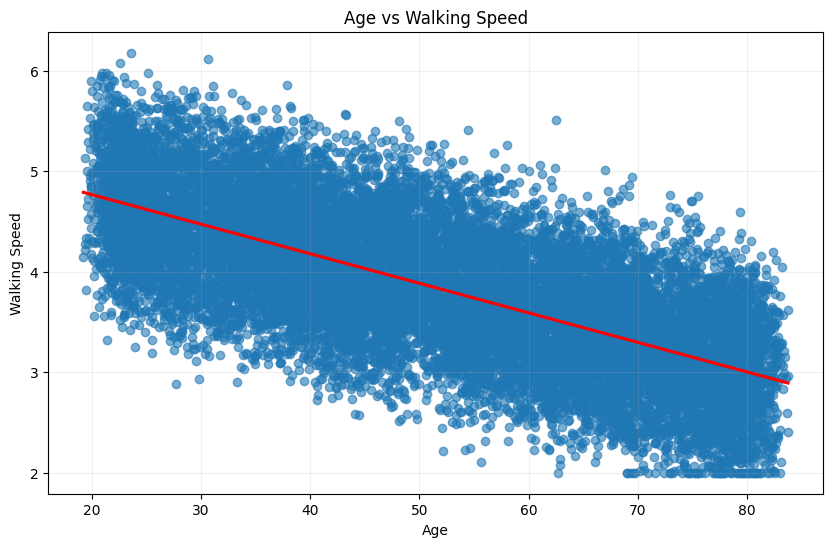

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df, 
    x='age', 
    y='walking_speed', 
    scatter_kws={'alpha': 0.6}, 
    line_kws={'color': 'red'}
)
plt.title('Age vs Walking Speed')
plt.xlabel('Age')
plt.ylabel('Walking Speed')
plt.grid(alpha=0.2)
plt.savefig("scatter_with_regression.png", dpi=300)
plt.show()



## Box plots by education level

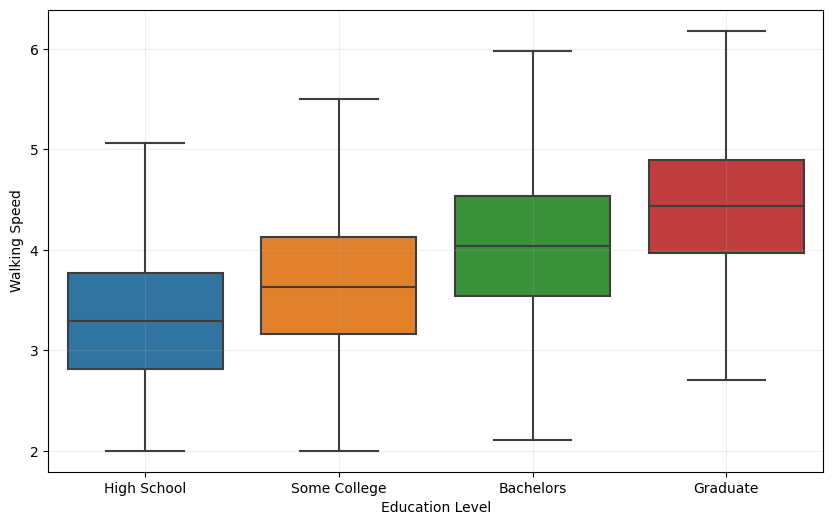

In [37]:
order = ["High School", "Some College", "Bachelors", "Graduate"]
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df, 
    x='education_level', 
    y='walking_speed', 
    order=order
)
plt.title('')
plt.xlabel('Education Level')
plt.ylabel('Walking Speed')
plt.grid(alpha=0.2)
plt.savefig("boxplot.png", dpi=300)
plt.show()

## Line plot showing education age interaction

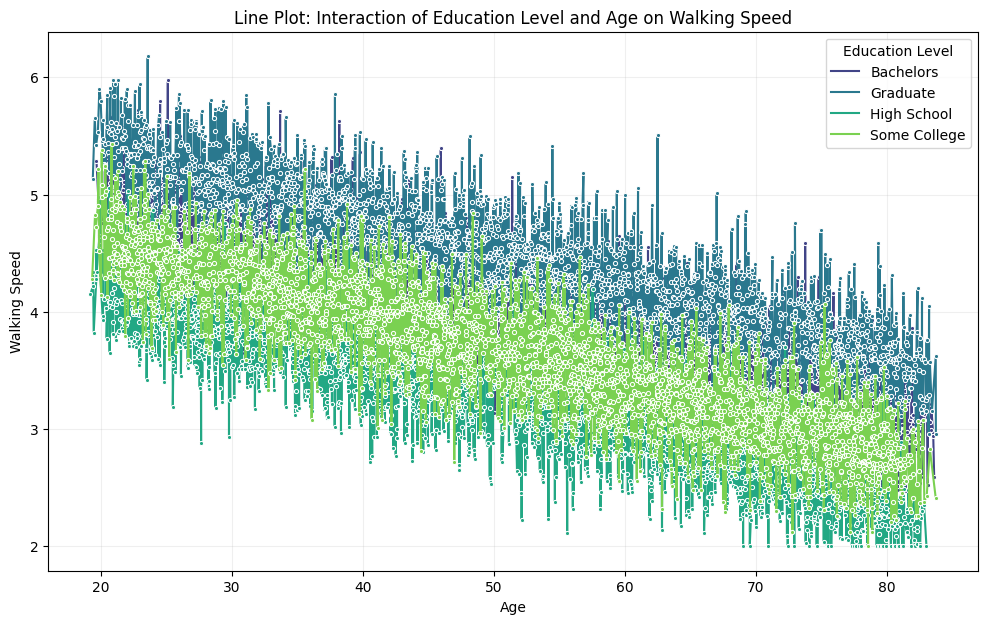

In [38]:
# Create means for interaction plot
interaction_data = df.groupby(['education_level', 'age']).walking_speed.mean().reset_index()

# Line plot for interaction effect
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=interaction_data, 
    x='age', 
    y='walking_speed', 
    hue='education_level', 
    palette='viridis',
    marker='.'
)
plt.title('Line Plot: Interaction of Education Level and Age on Walking Speed')
plt.xlabel('Age')
plt.ylabel('Walking Speed')
plt.legend(title='Education Level')
plt.grid(alpha=0.2)
plt.savefig("lineplot.png", dpi=300)
plt.show()


# Cost Analysis

## Bar plot of mean costs by insurance types

C:\Users\wammi\AppData\Local\Temp\ipykernel_52764\3621458793.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  insure = df.groupby('insurance_type').mean()
C:\Users\wammi\AppData\Local\Temp\ipykernel_52764\3621458793.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


                      age  walking_speed  visit_cost
insurance_type                                      
Basic           51.599245       3.826850  544.740924
Platinum        51.142941       3.838056  273.013963
Premium         51.794935       3.856143  434.801194


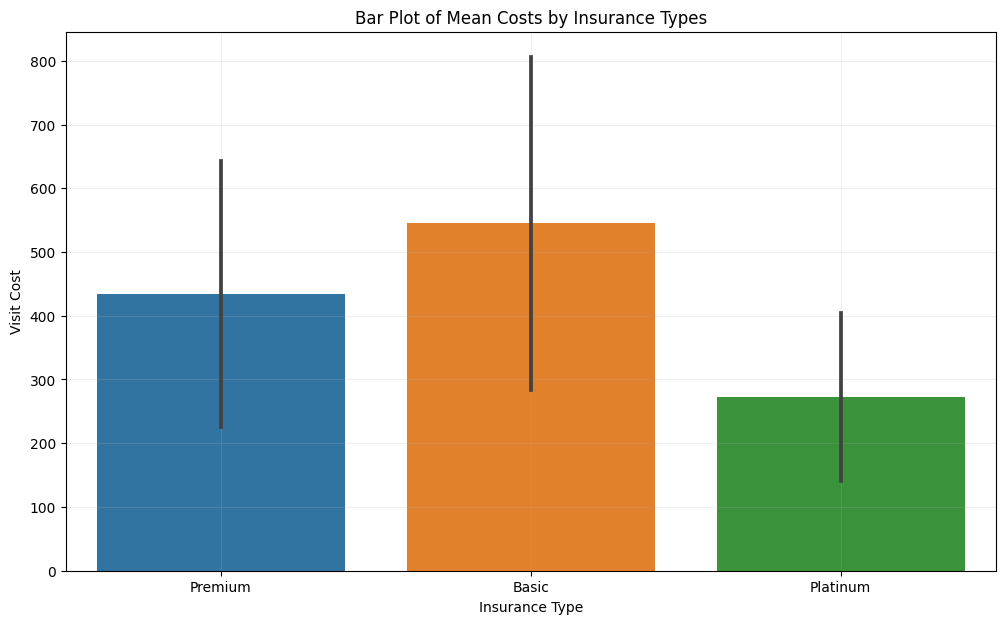

In [39]:
insure = df.groupby('insurance_type').mean()
print(insure)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=df, 
    x='insurance_type', 
    y='visit_cost', 
    ci='sd'
)
plt.title('Bar Plot of Mean Costs by Insurance Types')
plt.xlabel('Insurance Type')
plt.ylabel('Visit Cost')
plt.grid(alpha=0.2)
plt.savefig("barplot.png", dpi=300)
plt.show()


## Box plots showing cost distributions

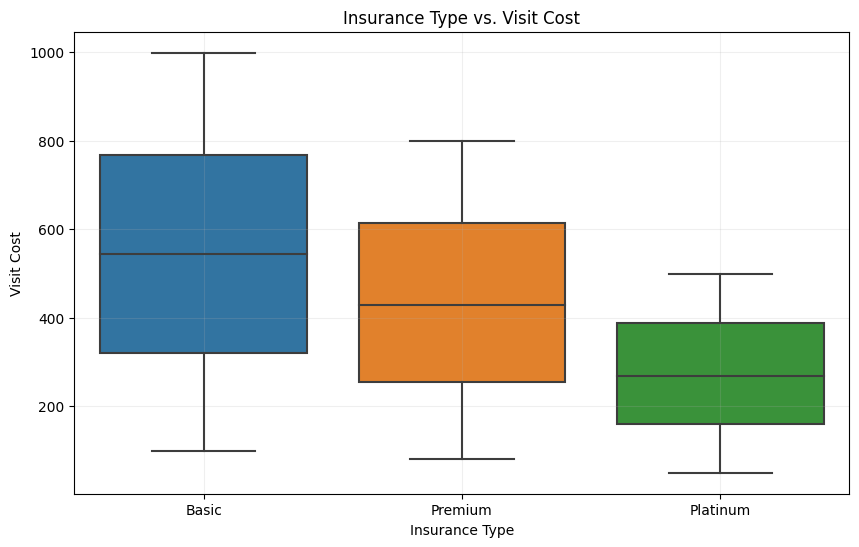

In [40]:
order = ["Basic", "Premium", "Platinum"]
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df, 
    x='insurance_type', 
    y='visit_cost', 
    order = order
)
plt.title('Insurance Type vs. Visit Cost')
plt.xlabel('Insurance Type')
plt.ylabel('Visit Cost')
plt.grid(alpha=0.2)
plt.savefig("boxplot_insurance.png", dpi=300)
plt.show()

# Combined Visuals

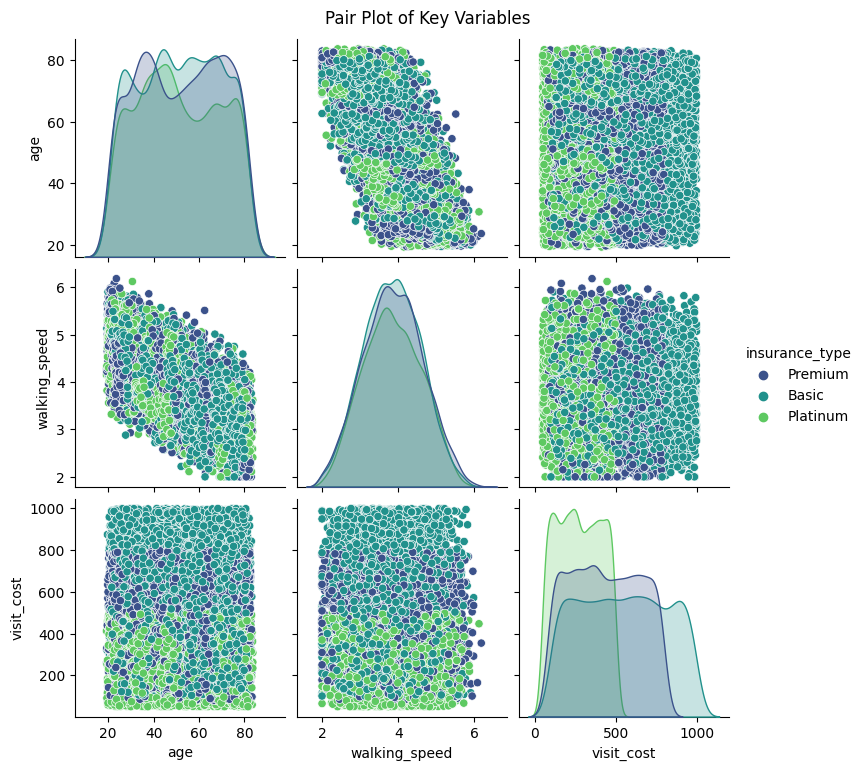

In [41]:
key_variables = ['age', 'walking_speed', 'visit_cost']

sns.pairplot(
    df, 
    vars=key_variables, 
    hue='insurance_type',  
    diag_kind='kde', 
    palette='viridis'
)
plt.suptitle('Pair Plot of Key Variables', y=1.02)
plt.savefig("pairplot.png", dpi=300)
plt.show()


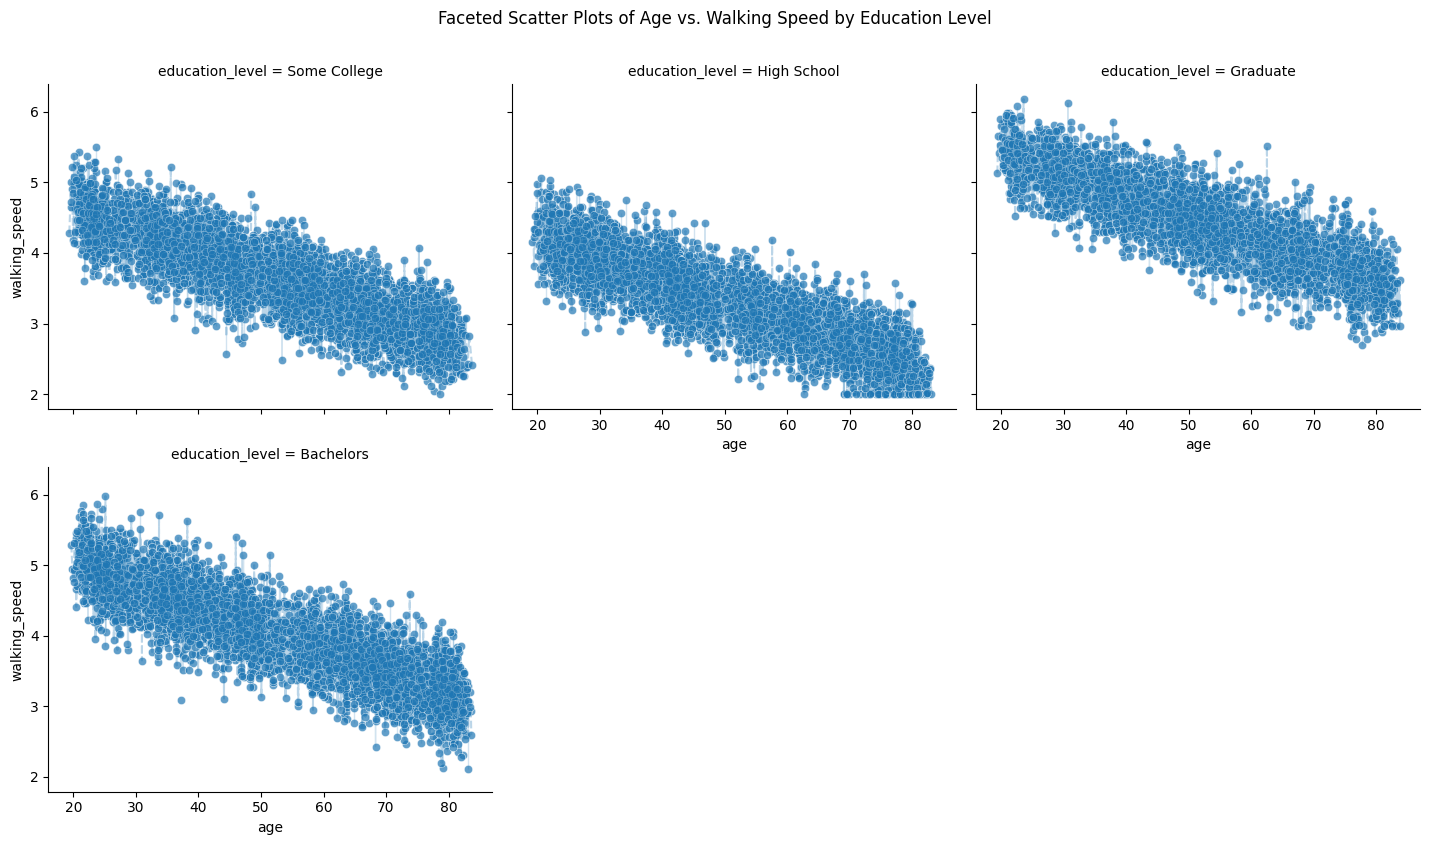

In [24]:
g = sns.FacetGrid(
    df, 
    col='education_level', 
    height=4, 
    aspect=1.2, 
    col_wrap=3,  # Adjust for multiple facets
    palette='viridis'
)
g.map(sns.scatterplot, 'age', 'walking_speed', alpha=0.7)
g.map(sns.lineplot, 'age', 'walking_speed', alpha=0.3, linestyle='--')  # Add trends

# Add a title
g.fig.suptitle('Faceted Scatter Plots of Age vs. Walking Speed by Education Level', y=1.05)
plt.show()


C:\Users\wammi\AppData\Local\Temp\ipykernel_52764\1168549968.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


<Figure size 1200x700 with 0 Axes>

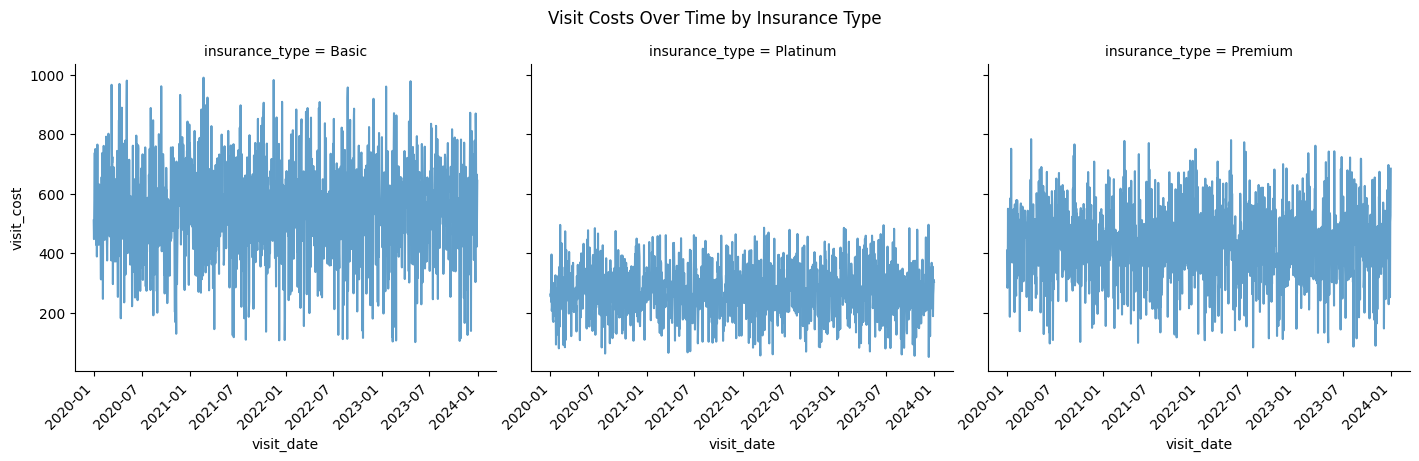

In [44]:
# Group by visit_date and insurance_type for trends
cost_trends = df.groupby(['visit_date', 'insurance_type'])['visit_cost'].mean().reset_index()

plt.figure(figsize=(12, 7))
# Line plot of visit costs over time, faceted by insurance type
g = sns.FacetGrid(
    cost_trends, 
    col='insurance_type', 
    height=4, 
    aspect=1.2, 
    col_wrap=3
)
g.map(sns.lineplot, 'visit_date', 'visit_cost', alpha=0.7)

g.fig.suptitle('Visit Costs Over Time by Insurance Type', y=1.05)
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig("facetGrid.png", dpi=300, bbox_inches='tight')
plt.show()
